# Lesson 7: Final Decisions

## Intro to Quantified Cognition

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2022_Fall/notebooks/07_Final_Decisions.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- Wiener First Passage of Time
- Timed Racing Diffusion Model
- Posterior Exploration
- Model Comparison


## Example: Speed--Accuracy trade-off

- Sometimes we have to make fast decisions
- Other times we just need to be as accurate as possible.

## If running locally with Anaconda

In [ ]:
# install numba (using anaconda, but may need to try pip)
!conda install numba

## *ONLY* if on Google Colab

In [ ]:
# install numba (use pip on Colab)
!pip install numba

In [ ]:
# to install RunDEMC
!pip install git+https://github.com/compmem/RunDEMC.git --upgrade


### To download data and models

In [ ]:
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/2022_Fall/notebooks/decision_data.csv

In [ ]:
# to retrieve the wfpt and trdm models
!wget https://raw.githubusercontent.com/compmem/QuantCog/2022_Fall/notebooks/nu_wfpt.py
!wget https://raw.githubusercontent.com/compmem/QuantCog/2022_Fall/notebooks/wald_race.py

## Load and process the data

In [1]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

from ipywidgets import interact, fixed

import arviz as az

from RunDEMC.density import kdensity
from RunDEMC import Model, Param, dists
from RunDEMC import DE, calc_bpic, joint_plot
from RunDEMC.io import arviz_dict

from nu_wfpt import wfpt_like, wfpt_gen
from waldrace import trdm_like, trdm_gen



In [2]:
# load in the data
dat = pd.read_csv('decision_data.csv', index_col=0)
dat = dat[dat.cond != 'Neutral']
dat['rt_acc'] = dat['rt']
dat.loc[dat.correct==0,'rt_acc'] = -dat['rt']
dat.head()

,correct,rt,cond,log_rt,rt_acc
3,1,0.4784,Accuracy,-0.737308,0.4784
4,1,0.4300,Accuracy,-0.843970,0.4300
5,1,0.4486,Accuracy,-0.801624,0.4486
6,1,0.3991,Speed,-0.918543,0.3991
8,1,0.4393,Accuracy,-0.822573,0.4393


## Wiener First Passage of Time (WFPT)

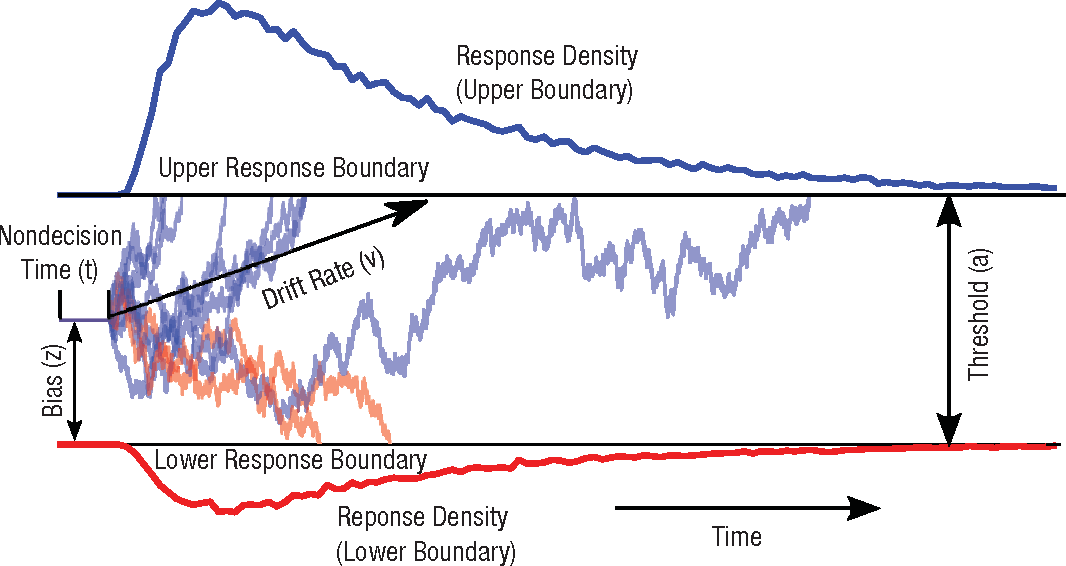


In [3]:
# set up the sim
nsims = 5000
cond='Accuracy'

# normed histogram
def dhist(dat, nvals, alpha=.3, color='b'):
    p,b = np.histogram(dat, bins='auto', density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nvals
    return plt.bar(b[1:]-w, p, width=w, alpha=.3, color=color)

# normed pdf
xvals = np.linspace(0.0,2.0,1000)

# put it all together
@interact(cond=['Accuracy', 'Speed'],
          v_mean=(-5,5.0,0.05),
          v_std=(0.0,5.0,0.05),
          a=(0.0,5.0,.05),
          w_mode=(0.0,1.0,.05),
          w_std=(0.0,1.0,.02),
          t0=(0.0,1.0,.02),
          S=fixed(1.0),
          nsamp=fixed(2000),
          err=fixed(.0001)
          )
def run_wfpt(cond, v_mean=1.75, a=1.5, w_mode=.5, w_std=0.0,
             v_std=0.0, t0=0.0, nsamp=5000, err=.0001):

    ndat = (dat['cond']==cond).sum()
    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
    likes = wfpt_like(np.ones(len(xvals))*2, xvals, v_mean, a, w_mode, w_std=w_std,
                      v_std=v_std, t0=0, nsamp=nsamp, err=err)
    plt.plot(xvals+t0, likes, color='b', lw=2.)
    
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
    likes = wfpt_like(np.ones(len(xvals))*1, xvals, v_mean, a, w_mode, w_std=w_std,
                      v_std=v_std, t0=0, nsamp=nsamp, err=err)
    plt.plot(xvals+t0, likes, color='r', lw=2.)
    #ylim(0,5.0)
    plt.xlim(0,2.0)

interactive(children=(Dropdown(description='cond', options=('Accuracy', 'Speed'), value='Accuracy'), FloatSlid…

## Using computers to test hypotheses

In [4]:
# grab the beh data of interest
choices_A = np.array(dat[(dat['cond']=='Accuracy')]['correct']+1)
rts_A = np.array(dat[(dat['cond']=='Accuracy')]['rt'])
choices_S = np.array(dat[(dat['cond']=='Speed')]['correct']+1)
rts_S = np.array(dat[(dat['cond']=='Speed')]['rt'])
min_rt = dat.rt.min()

In [61]:
# Test change in threshold and drift rate

# set up the params
params = [Param(name='v_A', prior=dists.normal(0., 2.)),
          Param(name='v_S', prior=dists.normal(0., 2.)),
          Param(name='w', prior=dists.normal(0, 1.4), transform=dists.invlogit),
          Param(name='a_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='a_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.normal(0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]
param_names = [p.name for p in params]

# define the likelihood function
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first Accuracy
        likes_A = wfpt_like(choices_A, rts_A, 
                            v_mean=p['v_A'], v_std=0.0, a=p['a_A'], 
                            w_mode=p['w'], t0=p['t0'], w_std=0.0, 
                            nsamp=1000)
        with np.errstate(divide='ignore'):
            likes[i] += np.log(likes_A).sum()
        if likes[i] == -np.inf:
            continue
            
        # then Speed
        likes_S = wfpt_like(choices_S, rts_S, 
                            v_mean=p['v_S'], v_std=0.0, a=p['a_S'], 
                            w_mode=p['w'], t0=p['t0'], w_std=0.0, 
                            nsamp=1000)
        with np.errstate(divide='ignore'):
            likes[i] += np.log(likes_S).sum()

    return likes

       
# make the model
m = Model('wfpt', params=params,
          like_fun=like_fun,
          pop_parallel=True,
          #num_chains=120,
          #like_args=(param_names,),
          #purify_every=5,
          verbose=True)


In [62]:
# do some burnin
times = m.sample(100, burnin=True)

Initializing: 120(120) 1(1) 
Iterations (100):


In [63]:
# sample from the posterior
times = m.sample(750, burnin=False)

Iterations (750):


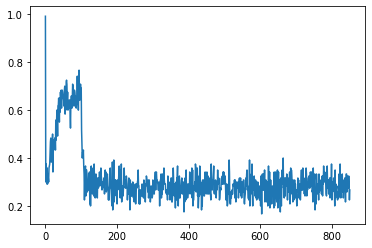

In [64]:
plt.plot(m.accept_rate)

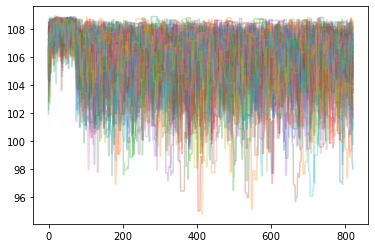

In [65]:
plt.plot(m.weights[30:], alpha=0.3);

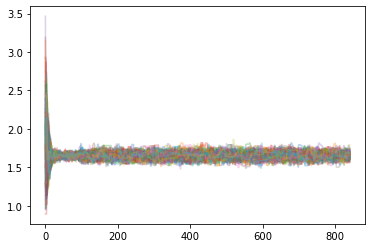

In [66]:
plt.plot(m.particles[10:, :, 3], alpha=0.3);

In [67]:
print("Best fitting params:")
burnin=200
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] 
         for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: 108.88348496812964
"v_A": 2.164301,
"v_S": 1.618581,
"w": 0.358885,
"a_A": 1.656191,
"a_S": 0.907414,
"t0": 0.202826,


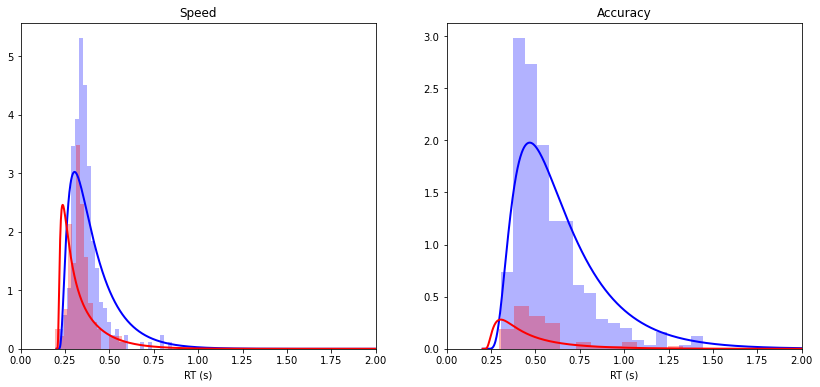

In [68]:
# set up new figure
plt.figure(figsize=(14,6))

# try different params!
plt.subplot(1,2,1)
cond='Speed'
run_wfpt(cond, v_mean=pp['v_S'], a=pp['a_S'], w_mode=pp['w'], t0=pp['t0'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

plt.subplot(1,2,2)
cond='Accuracy'
run_wfpt(cond, v_mean=pp['v_A'], a=pp['a_A'], w_mode=pp['w'], t0=pp['t0'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);


## Exploring the posterior

In [69]:
daz_w = az.from_dict(**arviz_dict(m, burnin=200, step=5))

In [70]:
az.summary(daz_w)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_A,2.157,0.117,1.948,2.385,0.002,0.001,4352.0,6550.0,1.02
v_S,1.624,0.152,1.339,1.908,0.002,0.002,4324.0,6820.0,1.02
w,0.358,0.014,0.332,0.383,0.000,0.000,4283.0,6845.0,1.02
a_A,1.652,0.045,1.569,1.736,0.001,0.000,4270.0,6305.0,1.02
a_S,0.906,0.022,0.866,0.947,0.000,0.000,4052.0,6829.0,1.03
t0,0.203,0.001,0.200,0.205,0.000,0.000,3990.0,6399.0,1.02


In [71]:
post = daz_w.posterior
post['v_A - v_S'] = post['v_A'] - post['v_S']
post['a_A - a_S'] = post['a_A'] - post['a_S']

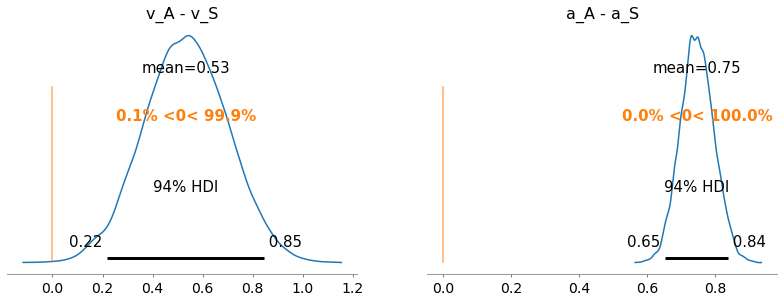

In [72]:
az.plot_posterior(daz_w, var_names=['v_A - v_S', 'a_A - a_S'], 
                  ref_val=0.0);

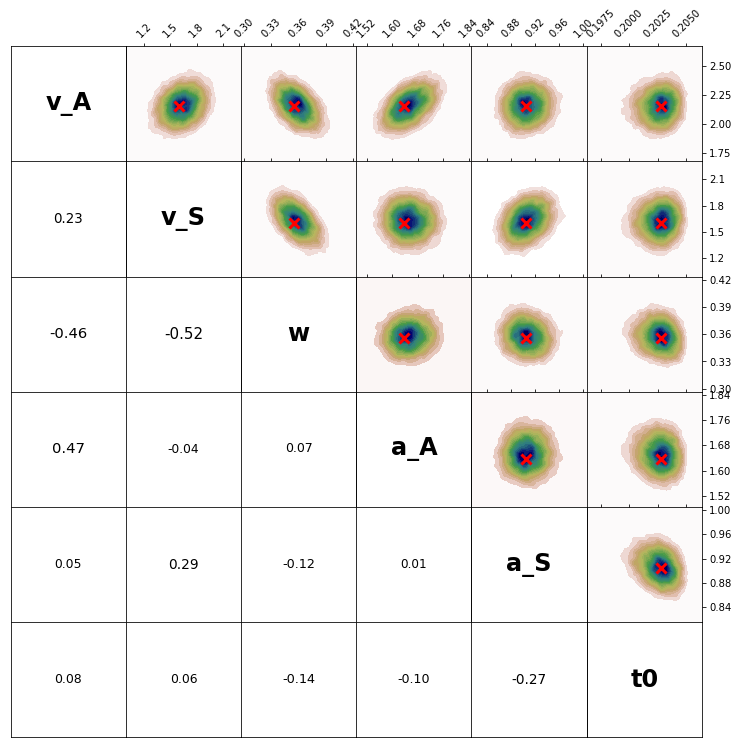

In [34]:
plt.figure(figsize=(12,12))

burnin = 200
joint_plot(m.particles, m.weights, burnin=burnin, 
           names=m.param_display_names, rot=45);

In [102]:
# save results out to file
daz_w.to_netcdf('07_wfpt_results.nc')

'09_wfpt_results.nc'

In [103]:
# show how to read it back in
daz_w2 = az.from_netcdf('07_wfpt_results.nc')
daz_w2.posterior

<xarray.Dataset>
Dimensions:  (chain: 60, draw: 401)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
Data variables:
    v_A      (chain, draw) float64 ...
    v_S      (chain, draw) float64 ...
    w        (chain, draw) float64 ...
    a_A      (chain, draw) float64 ...
    a_S      (chain, draw) float64 ...
    t0       (chain, draw) float64 ...
Attributes:
    created_at:     2021-04-01T16:58:21.476557
    arviz_version:  0.10.0

## Timed Racing Diffusion Model (TRDM; Hawkins & Heathcote, 2021)

![](./figs/Hawkins_Heathcote_TRDM.png)

In [49]:
# set up the sim
cond='Accuracy'

# normed histogram
def dhist(dat, nvals, alpha=.3, color='b'):
    p,b = np.histogram(dat, bins='auto', density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nvals
    return plt.bar(b[1:]-w, p, width=w, alpha=.3, color=color)

# normed pdf
xvals = np.linspace(0.0,2.0,1000)

# put it all together
@interact(cond=['Accuracy', 'Speed'],
          v_1=(0,5.0,0.05),
          v_2=(0,5.0,0.05),
          v_t=(0,5.0,0.05),
          theta=(0.0,0.5,.01),
          sig=(0.0,2.0,.05),
          sig_t=(0.0,4.0,.02),
          rho=(0.0,1.0,.02),
          )
def run_trdm(cond, v_1=0.25, v_2=0.75, v_t=0.1, theta=0.0,
             sig=1.0, sig_t=0.5, rho=0.0):

    ndat = (dat['cond']==cond).sum()
    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
    likes = trdm_like(np.ones(len(xvals))*2, xvals, 
                      v=[v_1, v_2, v_t], alpha=1.0, theta=[theta, theta, theta],
                      sig=[sig, sig, sig_t], rho=rho)
    plt.plot(xvals, likes, color='b', lw=2.)
    
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
    likes = trdm_like(np.ones(len(xvals))*1, xvals, 
                      v=[v_1, v_2, v_t], alpha=1.0, theta=[theta, theta, theta],
                      sig=[sig, sig, sig_t], rho=rho)
    plt.plot(xvals, likes, color='r', lw=2.)
    #ylim(0,5.0)
    plt.xlim(0,2.0)

interactive(children=(Dropdown(description='cond', options=('Accuracy', 'Speed'), value='Accuracy'), FloatSlid…

In [50]:
# Test change in timer

# set up the params
params = [Param(name='v1', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='v2', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='vt_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='vt_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='sig', prior=dists.halfcauchy(5.0)),
          Param(name='sig_t', prior=dists.halfcauchy(5.0)),
          Param(name='rho', prior=dists.normal(0, 1.4),
                transform=dists.invlogit),
          #Param(name='rho', prior=0.0),
          Param(name='t0', prior=dists.normal(0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]
param_names = [p.name for p in params]

# define the likelihood function
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first Accuracy
        likes_A = trdm_like(choices_A, rts_A, 
                            v=[p['v1'], p['v2'], p['vt_A']], 
                            alpha=1.0, 
                            theta=[p['t0'], p['t0'], p['t0']],
                            sig=[p['sig'], p['sig'], p['sig_t']], 
                            rho=p['rho'])
        with np.errstate(divide='ignore'):
            likes[i] += np.log(likes_A).sum()
        if likes[i] == -np.inf:
            continue
            
        # then Speed
        likes_S = trdm_like(choices_S, rts_S, 
                            v=[p['v1'], p['v2'], p['vt_S']], 
                            alpha=1.0, 
                            theta=[p['t0'], p['t0'], p['t0']],
                            sig=[p['sig'], p['sig'], p['sig_t']], 
                            rho=p['rho'])
        with np.errstate(divide='ignore'):
            likes[i] += np.log(likes_S).sum()

    return likes

       
# make the model
m = Model('trdm', params=params,
          like_fun=like_fun,
          pop_parallel=True,
          #num_chains=120,
          #like_args=(param_names,),
          #purify_every=5,
          verbose=True)


In [51]:
# do some burnin
times = m.sample(100, burnin=True)

Initializing: 160(160) 4(4) 
Iterations (100):


In [52]:
# sample from the posterior
times = m.sample(750, burnin=False)

Iterations (750):


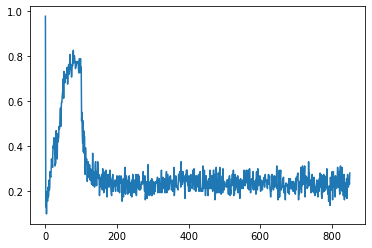

In [53]:
plt.plot(m.accept_rate)

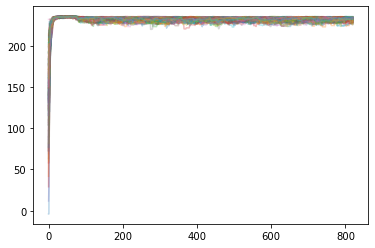

In [54]:
plt.plot(m.weights[30:], alpha=0.3);

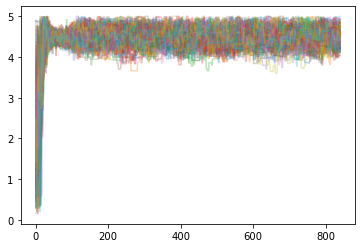

In [55]:
plt.plot(m.particles[10:, :, 3], alpha=0.3);

In [56]:
print("Best fitting params:")
burnin=200
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] 
         for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: 235.60297997162013
"v1": 0.183314,
"v2": 1.885394,
"vt_A": 1.000163,
"vt_S": 4.426214,
"sig": 0.612744,
"sig_t": 0.740369,
"rho": 0.429808,
"t0": 0.147017,


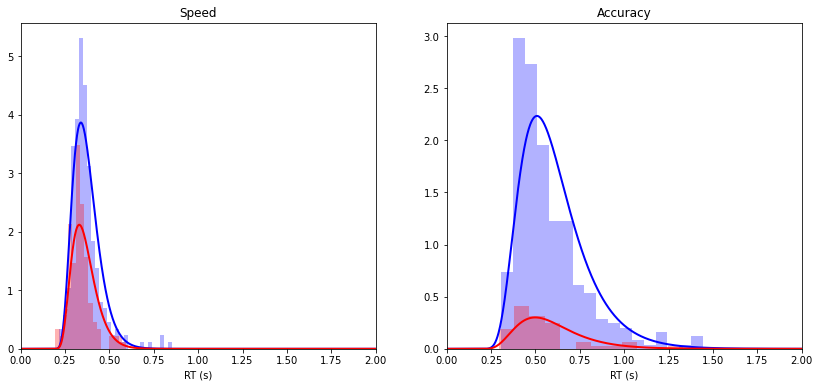

In [57]:
# set up new figure
plt.figure(figsize=(14,6))

# try different params!
plt.subplot(1,2,1)
cond='Speed'
run_trdm(cond, v_1=pp['v1'], v_2=pp['v2'], v_t=pp['vt_S'],
         theta=pp['t0'], sig=pp['sig'], sig_t=pp['sig_t'], rho=pp['rho'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

plt.subplot(1,2,2)
cond='Accuracy'
run_trdm(cond, v_1=pp['v1'], v_2=pp['v2'], v_t=pp['vt_A'],
         theta=pp['t0'], sig=pp['sig'], sig_t=pp['sig_t'], rho=pp['rho'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);


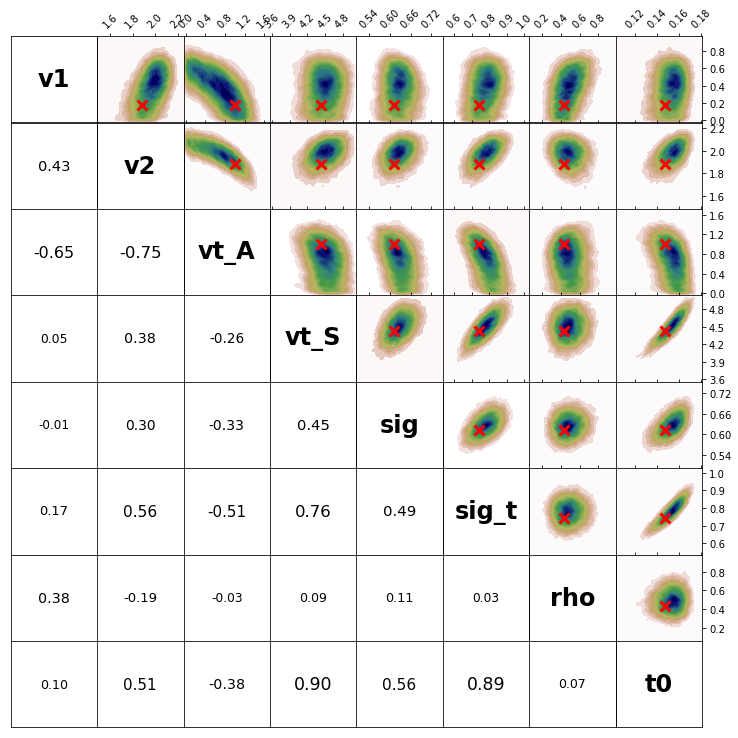

In [58]:
plt.figure(figsize=(12,12))

burnin = 200
joint_plot(m.particles, m.weights, burnin=burnin, 
           names=m.param_display_names, rot=45);

In [59]:
# save out model to an ArviZ Inference Dataset
daz_t = az.from_dict(**arviz_dict(m, burnin=200, step=3))
daz_t.posterior

<xarray.Dataset>
Dimensions:  (chain: 160, draw: 217)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 ... 152 153 154 155 156 157 158 159
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 209 210 211 212 213 214 215 216
Data variables:
    v1       (chain, draw) float64 0.4842 0.4842 0.4842 ... 0.6097 0.4731 0.4731
    v2       (chain, draw) float64 2.025 2.025 2.025 2.031 ... 1.984 1.961 1.961
    vt_A     (chain, draw) float64 0.3602 0.3602 0.3602 ... 0.8222 1.071 1.071
    vt_S     (chain, draw) float64 4.496 4.496 4.496 4.502 ... 4.582 4.397 4.397
    sig      (chain, draw) float64 0.6296 0.6296 0.6296 ... 0.5845 0.5957 0.5957
    sig_t    (chain, draw) float64 0.8207 0.8207 0.8207 ... 0.7997 0.7364 0.7364
    rho      (chain, draw) float64 0.4232 0.4232 0.4232 ... 0.5546 0.439 0.439
    t0       (chain, draw) float64 0.154 0.154 0.154 ... 0.1529 0.1489 0.1489
Attributes:
    created_at:     2022-10-06T14:11:52.279825
    arviz_version:  0.12.1

In [60]:
az.summary(daz_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v1,0.371,0.190,0.002,0.661,0.003,0.002,3598.0,5959.0,1.04
v2,1.964,0.099,1.775,2.142,0.002,0.002,2277.0,2489.0,1.05
vt_A,0.675,0.345,0.008,1.199,0.007,0.005,2348.0,3895.0,1.05
vt_S,4.491,0.208,4.109,4.887,0.004,0.003,2982.0,5638.0,1.04
sig,0.626,0.031,0.565,0.683,0.001,0.000,3029.0,5910.0,1.04
sig_t,0.778,0.062,0.663,0.894,0.001,0.001,2981.0,5713.0,1.04
rho,0.488,0.115,0.275,0.706,0.002,0.002,2831.0,3321.0,1.05
t0,0.152,0.010,0.133,0.169,0.000,0.000,3156.0,5464.0,1.04


In [129]:
# save results out to file
daz_t.to_netcdf('09_trdm_results.nc')

'09_trdm_results.nc'

## Model comparison with BPIC (Ando, 2007)

Lower is better!!!

In [73]:
print('TRDM:',calc_bpic(daz_t.log_likelihood['trdm'].values)['bpic'])
print('WFPT:',calc_bpic(daz_w.log_likelihood['wfpt'].values)['bpic'])

TRDM: -450.0279220983428
WFPT: -200.06742649389238


## The nature of the accumulation process (Kirkpatrick et al., 2021)

![](./figs/accumulators.png)